<p style="background-color: #0055A4; font-size: 48px; font-weight: bold; color: white; padding: 20px; text-align: center;">
🧹 Data Cleaning 
</p>


In [463]:
#Import librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math 
from scipy.stats import pearsonr
import scipy.stats as stats
from plotly.subplots import make_subplots
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore") 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew, shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter
from sklearn.feature_selection import SelectKBest
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from prettytable import PrettyTable
import featuretools as ft

In [464]:
#Import data
train_df = pd.read_csv('C:/Users/Mega-Pc/Freelance/data/fraudTrain.csv', delimiter=',', encoding='utf-8',index_col=0)
test_df = pd.read_csv('C:/Users/Mega-Pc/Freelance/data/fraudTest.csv', delimiter=',', encoding='utf-8',index_col=0)



## 🔄 Check for duplicates

In [465]:
#train_df
duplicate_count = train_df.duplicated().sum()
print(f'Number of duplicate records: {duplicate_count}')


Number of duplicate records: 0


In [466]:
#train_df
duplicate_count = test_df.duplicated().sum()
print(f'Number of duplicate records: {duplicate_count}')


Number of duplicate records: 0


## ✨ Data Transformation

## Log Transformation

In [467]:
#train_df + test_df
skewed_cols = ['amt','city_pop']
for col in skewed_cols:
    train_df[col] = np.log1p(train_df[col])  
    test_df[col] = np.log1p(test_df[col])
     




In [468]:
results = []
for var in  skewed_cols:
    skewness = stats.skew(train_df[var])
    kurtosis = stats.kurtosis(train_df[var])
    
    results.append({
        'Feature':  var ,
        'Skewness': skewness,
        'Kurtosis': kurtosis
    })

results_df = pd.DataFrame(results)

display(results_df)

,Feature,Skewness,Kurtosis
0,amt,-0.298852,-0.527247
1,city_pop,0.606094,-0.301258


## Handle outliers by capping them 

In [469]:
numerical_vars_filtered = [
    "amt",
    "zip",
    "lat",
    "long",
    "city_pop",
    "unix_time",
    "merch_lat",
    "merch_long"
]


In [470]:
#train_df
outliers_info = []

for col in numerical_vars_filtered:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    
    outliers_info.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': len(outliers),
        'Total Points': len(train_df)
    })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)


      Feature   Lower Bound   Upper Bound  Outliers Count  Total Points
0         amt -7.348234e-01  7.532865e+00             818       1296675
1         zip -4.247050e+04  1.407495e+05               0       1296675
2         lat  2.364065e+01  5.292025e+01            4679       1296675
3        long -1.217580e+02 -5.519800e+01           49922       1296675
4    city_pop  1.650397e+00  1.488145e+01            4168       1296675
5   unix_time  1.307799e+09  1.390337e+09               0       1296675
6   merch_lat  2.389818e+01  5.279255e+01            4967       1296675
7  merch_long -1.218880e+02 -5.524608e+01           41994       1296675


In [471]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

columns_with_outliers = [
    "amt",
    "lat",
    "long",
    "city_pop",
    "merch_lat",
    "merch_long"
]

for col in columns_with_outliers:
    train_df = handle_outliers(train_df, col)


In [472]:
# results after capping outliers
outliers_info = []

for col in numerical_vars_filtered:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    
    outliers_info.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': len(outliers),
        'Total Points': len(train_df)
    })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)


      Feature   Lower Bound   Upper Bound  Outliers Count  Total Points
0         amt -7.348234e-01  7.532865e+00               0       1296675
1         zip -4.247050e+04  1.407495e+05               0       1296675
2         lat  2.364065e+01  5.292025e+01               0       1296675
3        long -1.217580e+02 -5.519800e+01               0       1296675
4    city_pop  1.650397e+00  1.488145e+01               0       1296675
5   unix_time  1.307799e+09  1.390337e+09               0       1296675
6   merch_lat  2.389818e+01  5.279255e+01               0       1296675
7  merch_long -1.218880e+02 -5.524608e+01               0       1296675


In [473]:
#test_df
outliers_info = []

for col in numerical_vars_filtered:
    Q1 = test_df[col].quantile(0.25)
    Q3 = test_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = test_df[(test_df[col] < lower_bound) | (test_df[col] > upper_bound)]
    
    outliers_info.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': len(outliers),
        'Total Points': len(train_df)
    })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)


      Feature   Lower Bound   Upper Bound  Outliers Count  Total Points
0         amt -7.372033e-01  7.531819e+00             402       1296675
1         zip -4.228650e+04  1.405895e+05               0       1296675
2         lat  2.383005e+01  5.273365e+01            1933       1296675
3        long -1.217322e+02 -5.524100e+01           21104       1296675
4    city_pop  1.691879e+00  1.480513e+01            1697       1296675
5   unix_time  1.361271e+09  1.400625e+09               0       1296675
6   merch_lat  2.395701e+01  5.275246e+01            2090       1296675
7  merch_long -1.218659e+02 -5.530390e+01           17926       1296675


In [474]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

columns_with_outliers = [
    "amt",
    "lat",
    "long",
    "city_pop",
    "merch_lat",
    "merch_long"
]

for col in columns_with_outliers:
    train_df = handle_outliers(test_df, col)


In [475]:
# results after capping outliers
outliers_info = []

for col in numerical_vars_filtered:
    Q1 = test_df[col].quantile(0.25)
    Q3 = test_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = test_df[(test_df[col] < lower_bound) | (test_df[col] > upper_bound)]
    
    outliers_info.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': len(outliers),
        'Total Points': len(train_df)
    })

outliers_df = pd.DataFrame(outliers_info)
print(outliers_df)


      Feature   Lower Bound   Upper Bound  Outliers Count  Total Points
0         amt -7.372033e-01  7.531819e+00               0        555719
1         zip -4.228650e+04  1.405895e+05               0        555719
2         lat  2.383005e+01  5.273365e+01               0        555719
3        long -1.217322e+02 -5.524100e+01               0        555719
4    city_pop  1.691879e+00  1.480513e+01               0        555719
5   unix_time  1.361271e+09  1.400625e+09               0        555719
6   merch_lat  2.395701e+01  5.275246e+01               0        555719
7  merch_long -1.218659e+02 -5.530390e+01               0        555719


## Feature Engineering

In [476]:
# Train dataset
datetime_cols_train = train_df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
print("Datetime columns in train_df:", datetime_cols_train)

# Test dataset
datetime_cols_test = test_df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
print("Datetime columns in test_df:", datetime_cols_test)


Datetime columns in train_df: []
Datetime columns in test_df: []


In [477]:
for df in [train_df, test_df]:
    df["dob"] = pd.to_datetime(df["dob"], errors="coerce")  

for df in [train_df, test_df]:
    df["dob_year"] = df["dob"].dt.year
    df["dob_month"] = df["dob"].dt.month
    df["dob_day"] = df["dob"].dt.day


In [478]:
# extract age

from datetime import datetime
def add_age_feature(df):
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
    today_year = datetime.today().year
    df['age'] = today_year - df['dob'].dt.year

    df['age_group'] = pd.cut(
        df['age'],
        bins=[0, 25, 40, 60, 100],
        labels=['young', 'adult', 'mature', 'senior'] 
    )
    
    return df


train_df = add_age_feature(train_df)
test_df = add_age_feature(test_df)

In [479]:
# transaction amount per city pop and categorization into bins
def add_transaction_features(df):
    
    #Transaction amount per city pop
    df["amt_per_capita"] = df["amt"] / (df["city_pop"] + 1)  
    
    #Transaction amount bins 
    df["amt_category"] = pd.qcut(df["amt"], q=3, labels=["low", "medium", "high"]) 
    
    return df

# Apply to both train and test
train_df = add_transaction_features(train_df)
test_df = add_transaction_features(test_df)




In [480]:
#distance between customer and merchant (3 methods)

def haversine_distance(lat1, lon1, lat2, lon2):
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371  
    return c * r

def add_distance_features(df):
    df["haversine_dist"] = haversine_distance(
        df["lat"], df["long"], df["merch_lat"], df["merch_long"]
    )
    
    df["manhattan_dist"] = (
        abs(df["lat"] - df["merch_lat"]) + abs(df["long"] - df["merch_long"])
    )
    
    df["euclidean_dist"] = np.sqrt(
        (df["lat"] - df["merch_lat"])**2 + (df["long"] - df["merch_long"])**2
    )
    
    return df


train_df = add_distance_features(train_df)
test_df = add_distance_features(test_df)





In [481]:
# customer level aggregation features 
def add_customer_agg_features(train_df, test_df):
    customer_stats = train_df.groupby("cc_num").agg(
        avg_transaction_amt=("amt", "mean"),
        std_transaction_amt=("amt", "std"),
        transaction_count=("amt", "count")
    ).reset_index()
    
    train_df = train_df.merge(customer_stats, on="cc_num", how="left")
    
    test_df = test_df.merge(customer_stats, on="cc_num", how="left")
    
    train_df["std_transaction_amt"].fillna(0, inplace=True)
    test_df["std_transaction_amt"].fillna(0, inplace=True)
    
    return train_df, test_df


train_df, test_df = add_customer_agg_features(train_df, test_df)



In [482]:
#transaction velocity (1hour/24hours/7days)

def add_transaction_velocity(df):
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
    df = df.sort_values(by=["cc_num", "trans_date_trans_time"]).reset_index(drop=True)
    
    tx_1h = np.zeros(len(df), dtype=int)
    tx_24h = np.zeros(len(df), dtype=int)
    tx_7d = np.zeros(len(df), dtype=int)
    
    for cust_id, group in df.groupby("cc_num", sort=False):
        idx = group.index.values
        times = group["trans_date_trans_time"].values.astype("datetime64[ns]")
        times_ns = times.astype("int64")
        
        one_hour = np.timedelta64(1, "h").astype("int64")
        one_day = np.timedelta64(1, "D").astype("int64")
        seven_days = np.timedelta64(7, "D").astype("int64")
        
        for arr, window in [(tx_1h, one_hour), (tx_24h, one_day), (tx_7d, seven_days)]:
            left_idx = np.searchsorted(times_ns, times_ns - window, side="left")
            count = np.arange(len(times)) - left_idx
            arr[idx] = count
    
    df["tx_count_last_1h"] = tx_1h
    df["tx_count_last_24h"] = tx_24h
    df["tx_count_last_7d"] = tx_7d
    
    return df

train_df = add_transaction_velocity(train_df)
test_df = add_transaction_velocity(test_df)


In [483]:
#Transaction Amount Deviation to capture how unusual a transaction is for a customer

#amt_diff_mean=current transaction minus customer’s mean transaction amount
#amt_diff_std =current transaction – mean) divided by customer’s std
#amt_ratio_mean=ratio of current transaction to customer’s mean

def add_amount_deviation_features(train_df, test_df):
    customer_stats = train_df.groupby("cc_num")["amt"].agg(["mean", "std"]).reset_index()
    customer_stats.rename(columns={"mean": "cust_amt_mean", "std": "cust_amt_std"}, inplace=True)
    
    train_df = train_df.merge(customer_stats, on="cc_num", how="left")
    test_df = test_df.merge(customer_stats, on="cc_num", how="left")
    
    train_df["cust_amt_std"].fillna(0, inplace=True)
    test_df["cust_amt_std"].fillna(0, inplace=True)
    
    for df in [train_df, test_df]:
        df["amt_diff_mean"] = df["amt"] - df["cust_amt_mean"]
        df["amt_diff_std"] = (df["amt"] - df["cust_amt_mean"]) / (df["cust_amt_std"] + 1e-6)
        df["amt_ratio_mean"] = df["amt"] / (df["cust_amt_mean"] + 1e-6)
    
    return train_df, test_df


train_df, test_df = add_amount_deviation_features(train_df, test_df)




In [484]:
#Merchant-Level Aggregation Features because fraud can target certain merchants or categories

#merchant_avg_amt=average transaction amount per merchant
#merchant_tx_count=number of transactions per merchant
#merchant_fraud_rate =fraud rate per merchant 

def add_merchant_agg_features(train_df, test_df):
    merchant_stats = train_df.groupby("merchant").agg(
        merchant_avg_amt=("amt", "mean"),
        merchant_tx_count=("amt", "count"),
        merchant_fraud_rate=("is_fraud", "mean") 
    ).reset_index()
    
    train_df = train_df.merge(merchant_stats, on="merchant", how="left")
    test_df = test_df.merge(merchant_stats, on="merchant", how="left")

    global_fraud_rate = train_df["is_fraud"].mean()
    test_df["merchant_fraud_rate"].fillna(global_fraud_rate, inplace=True)
    
    return train_df, test_df

train_df, test_df = add_merchant_agg_features(train_df, test_df)



In [485]:
# city fraud rate & state fraud rate

def add_geographical_features(train_df, test_df):
    state_stats = train_df.groupby("state")["is_fraud"].mean().reset_index()
    state_stats.rename(columns={"is_fraud": "state_fraud_rate"}, inplace=True)

    city_stats = train_df.groupby("city")["is_fraud"].mean().reset_index()
    city_stats.rename(columns={"is_fraud": "city_fraud_rate"}, inplace=True)
    
    train_df = train_df.merge(state_stats, on="state", how="left")
    train_df = train_df.merge(city_stats, on="city", how="left")
    
    test_df = test_df.merge(state_stats, on="state", how="left")
    test_df = test_df.merge(city_stats, on="city", how="left")
    
    global_fraud_rate = train_df["is_fraud"].mean()
    test_df["state_fraud_rate"].fillna(global_fraud_rate, inplace=True)
    test_df["city_fraud_rate"].fillna(global_fraud_rate, inplace=True)
    
    return train_df, test_df


train_df, test_df = add_geographical_features(train_df, test_df)



In [486]:
# credit card number related features 

# average transaction ampunt per card
cc_mean_amt = train_df.groupby("cc_num")["amt"].mean()
train_df["cc_avg_amt"] = train_df["cc_num"].map(cc_mean_amt)
test_df["cc_avg_amt"] = test_df["cc_num"].map(cc_mean_amt)

global_mean = train_df["amt"].mean()
test_df["cc_avg_amt"].fillna(global_mean, inplace=True)




In [487]:
#fraud rate per card 

cc_fraud_rate = train_df.groupby("cc_num")["is_fraud"].mean()
train_df["cc_fraud_rate"] = train_df["cc_num"].map(cc_fraud_rate)
test_df["cc_fraud_rate"] = test_df["cc_num"].map(cc_fraud_rate)

global_fraud_rate = train_df["is_fraud"].mean()
test_df["cc_fraud_rate"].fillna(global_fraud_rate, inplace=True)

In [488]:
# number of transcations per cc in a recent time window
def add_transaction_velocity(df):
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
    df = df.sort_values(by=["cc_num", "trans_date_trans_time"])
    
    df["tx_count_last_1h"] = 0
    df["tx_count_last_24h"] = 0
    df["tx_count_last_7d"] = 0
    
    for cc in df["cc_num"].unique():
        cc_df = df[df["cc_num"] == cc]
        cc_df = cc_df.set_index("trans_date_trans_time")
        
        # Rolling counts
        df.loc[cc_df.index, "tx_count_last_1h"] = cc_df.rolling("1h").count()["cc_num"] - 1
        df.loc[cc_df.index, "tx_count_last_24h"] = cc_df.rolling("1d").count()["cc_num"] - 1
        df.loc[cc_df.index, "tx_count_last_7d"] = cc_df.rolling("7d").count()["cc_num"] - 1
    
    return df


## Encoding

In [489]:

le_age = LabelEncoder()
le_amt = LabelEncoder()


train_df['age_group_encoded'] = le_age.fit_transform(train_df['age_group'])
test_df['age_group_encoded'] = le_age.transform(test_df['age_group'])

train_df['amt_category_encoded'] = le_amt.fit_transform(train_df['amt_category'])
test_df['amt_category_encoded'] = le_amt.transform(test_df['amt_category'])

train_df.drop(['age_group', 'amt_category'], axis=1, inplace=True)
test_df.drop(['age_group', 'amt_category'], axis=1, inplace=True)


In [490]:
categorical_columns = [col for col in train_df.columns if train_df[col].dtype == 'object']

unique_counts = {}
for col in categorical_columns:
    unique_counts[col] = {
        "train_unique": train_df[col].nunique(),
        "test_unique": test_df[col].nunique()
    }

unique_counts


{'merchant': {'train_unique': 693, 'test_unique': 693},
 'category': {'train_unique': 14, 'test_unique': 14},
 'first': {'train_unique': 341, 'test_unique': 341},
 'last': {'train_unique': 471, 'test_unique': 471},
 'gender': {'train_unique': 2, 'test_unique': 2},
 'street': {'train_unique': 924, 'test_unique': 924},
 'city': {'train_unique': 849, 'test_unique': 849},
 'state': {'train_unique': 50, 'test_unique': 50},
 'job': {'train_unique': 478, 'test_unique': 478},
 'trans_num': {'train_unique': 555719, 'test_unique': 555719}}

In [491]:
# Low-cardinality = One-hot encoding
onehot_cols = ["category", "gender", "state"]

# High-cardinality = Target encoding
target_cols = ["merchant", "first", "last", "street", "city", "job"]

# ---------------------------
# One-hot encoding
# ---------------------------
combined = pd.concat([train_df[onehot_cols], test_df[onehot_cols]], axis=0)
combined_onehot = pd.get_dummies(combined, columns=onehot_cols, dtype=float)  

train_onehot = combined_onehot.iloc[:len(train_df), :].reset_index(drop=True)
test_onehot = combined_onehot.iloc[len(train_df):, :].reset_index(drop=True)

train_df = pd.concat([train_df.drop(columns=onehot_cols), train_onehot], axis=1)
test_df = pd.concat([test_df.drop(columns=onehot_cols), test_onehot], axis=1)

# ---------------------------
# Target encoding for high-cardinality columns
# ---------------------------
def target_encode(train, test, col, target="is_fraud"):
    mean_map = train.groupby(col)[target].mean()
    train_encoded = train[col].map(mean_map)
    test_encoded = test[col].map(mean_map)
    global_mean = train[target].mean()
    test_encoded.fillna(global_mean, inplace=True)
    return train_encoded.astype(float), test_encoded.astype(float)  # ensure numeric

for col in target_cols:
    train_df[col], test_df[col] = target_encode(train_df, test_df, col, target="is_fraud")


## Feature Selection

In [492]:
drop_cols = ["trans_num","trans_date_trans_time","dob"]
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)


In [493]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'cc_num']

# Compute correlation with target
target_col = 'is_fraud'
features_for_corr = numeric_features.copy()
if target_col not in features_for_corr:
    features_for_corr.append(target_col)

correlation_with_target = train_df[features_for_corr].corr()[target_col].sort_values()

# Interactive bar chart
pastel_blue_colors = ['#b0d0f3', '#93c9e6', '#7cb9d4', '#6ca3c1', '#4f87a3']

fig = px.bar(
    x=correlation_with_target.index,
    y=correlation_with_target.values,
    labels={"x": "Features", "y": "Pearson Correlation Coefficient"},
    title=f"Correlation of Numeric Features with Target ({target_col})",
    color=correlation_with_target.values,
    color_continuous_scale=pastel_blue_colors
)

fig.update_layout(
    xaxis=dict(title="Features", tickangle=45),
    yaxis=dict(title="Pearson Correlation Coefficient"),
    coloraxis_colorbar=dict(title="Correlation Coefficient"),
    height=600,
    width=1000
)

fig.show()

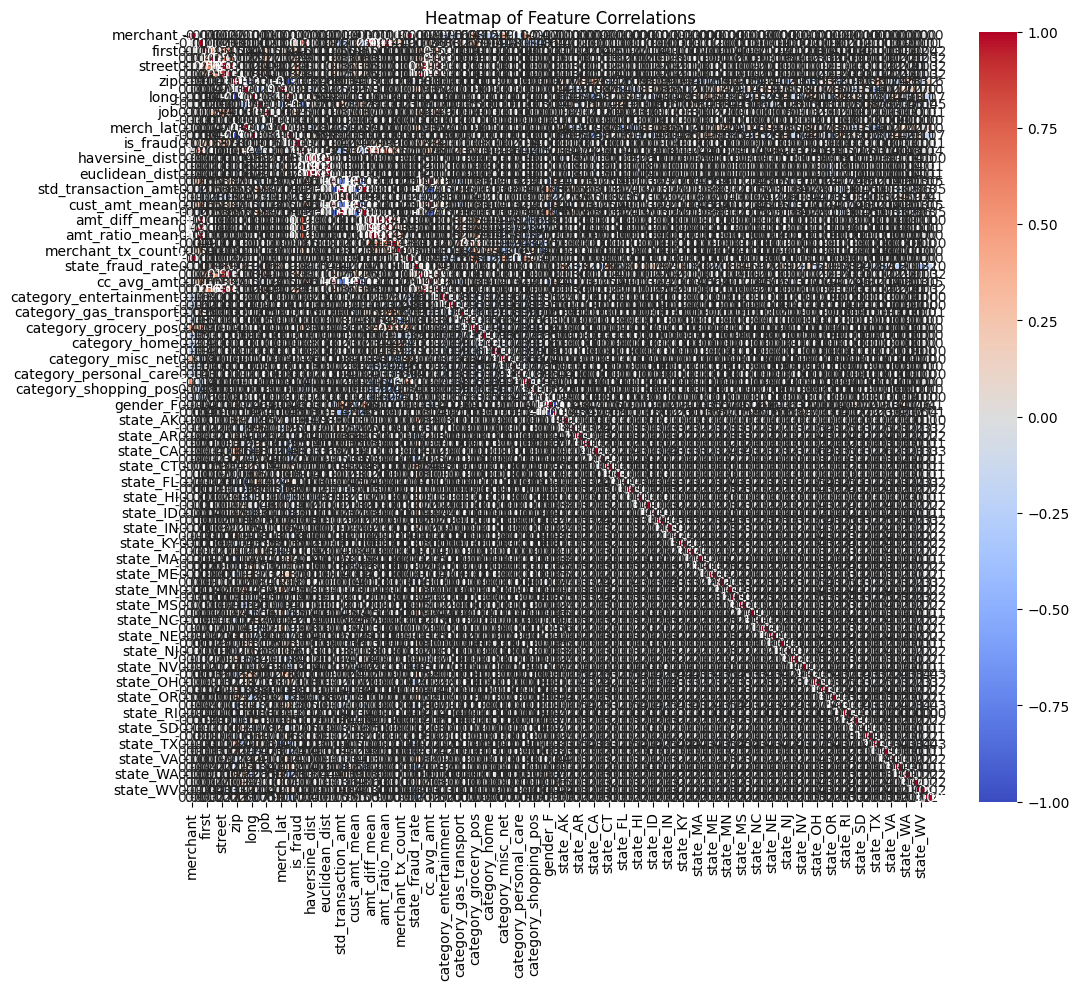

These features are positively correlated (>|0.9|):
merchant and merchant_fraud_rate: 1.00
amt and amt_diff_mean: 0.96
amt and amt_diff_std: 0.95
amt and amt_ratio_mean: 0.96
street and city: 0.91
street and city_fraud_rate: 0.91
street and cc_fraud_rate: 1.00
city and street: 0.91
city and city_fraud_rate: 1.00
city and cc_fraud_rate: 0.91
lat and merch_lat: 0.99
long and merch_long: 1.00
merch_lat and lat: 0.99
merch_long and long: 1.00
haversine_dist and manhattan_dist: 0.95
haversine_dist and euclidean_dist: 0.98
manhattan_dist and haversine_dist: 0.95
manhattan_dist and euclidean_dist: 0.98
euclidean_dist and haversine_dist: 0.98
euclidean_dist and manhattan_dist: 0.98
avg_transaction_amt and cust_amt_mean: 1.00
avg_transaction_amt and cc_avg_amt: 1.00
std_transaction_amt and cust_amt_std: 1.00
cust_amt_mean and avg_transaction_amt: 1.00
cust_amt_mean and cc_avg_amt: 1.00
cust_amt_std and std_transaction_amt: 1.00
amt_diff_mean and amt: 0.96
amt_diff_mean and amt_diff_std: 0.98
amt

In [494]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['cc_num']]

corr_matrix = train_df[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 10})
plt.title("Heatmap of Feature Correlations")
plt.show()

positive_corr = []
negative_corr = []

for row in corr_matrix.columns:
    for col in corr_matrix.columns:
        if row != col:
            if corr_matrix.loc[row, col] > 0.9:
                positive_corr.append((row, col, corr_matrix.loc[row, col]))
            elif corr_matrix.loc[row, col] < -0.9:
                negative_corr.append((row, col, corr_matrix.loc[row, col]))

if positive_corr:
    print("These features are positively correlated (>|0.9|):")
    for pair in positive_corr:
        print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")
else:
    print("No positive correlations (>|0.9|) found.")

if negative_corr:
    print("\nThese features are negatively correlated (<-0.9):")
    for pair in negative_corr:
        print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")
else:
    print("No negative correlations (<-0.9) found.")

In [495]:
from tabulate import tabulate

numeric_cols = train_df.select_dtypes(include=["number"]).columns.drop("is_fraud")
variances = train_df[numeric_cols].var()
variance_table = [(col, variance) for col, variance in variances.items()]
print("Variance of each numeric feature:")
print(tabulate(variance_table, headers=["Feature", "Variance"], tablefmt="pretty"))

low_variance_features = variances[variances < 0.01].index.tolist()

low_variance_table = [(col, variances[col]) for col in low_variance_features]
print("\nLow variance numeric features (variance < 0.01):")
print(tabulate(low_variance_table, headers=["Feature", "Variance"], tablefmt="pretty"))


Variance of each numeric feature:
+-------------------------+------------------------+
|         Feature         |        Variance        |
+-------------------------+------------------------+
|         cc_num          | 1.7156719789009967e+36 |
|        merchant         | 1.743196768214951e-05  |
|           amt           |   1.6497940984550015   |
|          first          | 0.00010317935734240467 |
|          last           | 0.0001446465941599268  |
|         street          | 0.0003641620125868466  |
|          city           | 0.00030419529470871224 |
|           zip           |   721206242.6041212    |
|           lat           |   24.626604335982066   |
|          long           |   173.0402987218621    |
|        city_pop         |   5.991214947578466    |
|           job           | 8.836159021827118e-05  |
|        unix_time        |   27051483504490.08    |
|        merch_lat        |   24.96519159307983    |
|       merch_long        |   173.50648214229065   |
|        dob

In [496]:
#drop low  variance features
train_df.drop(columns=low_variance_features, inplace=True)
test_df.drop(columns=low_variance_features, inplace=True)

## Chi Squared Test

In [497]:
X_train = train_df.drop(columns=['is_fraud'])  
y_train = train_df['is_fraud']  

X_test = test_df.drop(columns=['is_fraud'])  
y_test = test_df['is_fraud']  


In [498]:
target = [col for col in train_df.columns if col == 'is_fraud']
col = list(train_df.columns)
categorical_features = []
discrete_features = []
for i in col:
    if len(train_df[i].unique()) > 6:
        discrete_features.append(i)
    else:
        categorical_features.append(i)

light_blue = '\033[94m'
reset_color = '\033[0m'

print(f"{light_blue}Categorical features ({len(categorical_features)}):{reset_color}", *categorical_features)
print(f"{light_blue}Target Variable ({len(target)}):{reset_color}", target)
print(f"{light_blue}Discrete features ({len(discrete_features)}):{reset_color}", *discrete_features)


Categorical features (55): is_fraud age_group_encoded amt_category_encoded category_entertainment category_food_dining category_gas_transport category_grocery_net category_grocery_pos category_health_fitness category_home category_kids_pets category_misc_net category_misc_pos category_personal_care category_shopping_net category_shopping_pos category_travel gender_F gender_M state_AL state_AR state_CA state_CO state_FL state_GA state_IA state_IL state_IN state_KS state_KY state_LA state_MD state_ME state_MI state_MN state_MO state_MS state_NC state_ND state_NE state_NJ state_NM state_NY state_OH state_OK state_OR state_PA state_SC state_TN state_TX state_VA state_WA state_WI state_WV state_WY
Target Variable (1): ['is_fraud']
Discrete features (28): cc_num amt zip lat long city_pop unix_time merch_lat merch_long dob_year dob_month dob_day age amt_per_capita haversine_dist manhattan_dist euclidean_dist avg_transaction_amt std_transaction_amt transaction_count cust_amt_mean cust_amt_std 

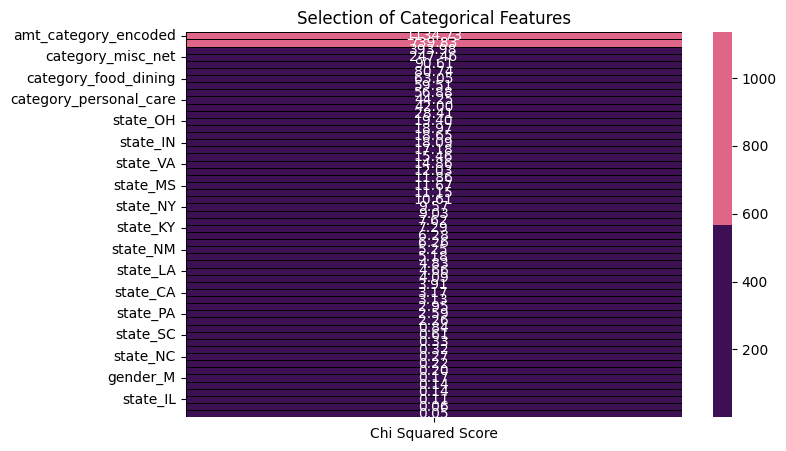

In [499]:
from sklearn.feature_selection import SelectKBest, chi2
colors = ['#3C1053', '#DF6589']
flag_columns = [col for col in categorical_features if col not in ['is_fraud']]

fig, ax = plt.subplots(figsize=(8, 5))

features = X_train.loc[:, flag_columns].clip(lower=0) 
target = y_train

best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(features, target)

featureScores_train = pd.DataFrame(data=fit.scores_, index=features.columns, columns=['Chi Squared Score'])
sorted_featureScores_train = featureScores_train.sort_values(ascending=False, by='Chi Squared Score')

sns.heatmap(sorted_featureScores_train, annot=True, cmap=colors, linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Categorical Features')
plt.show()


## ANOVA Test

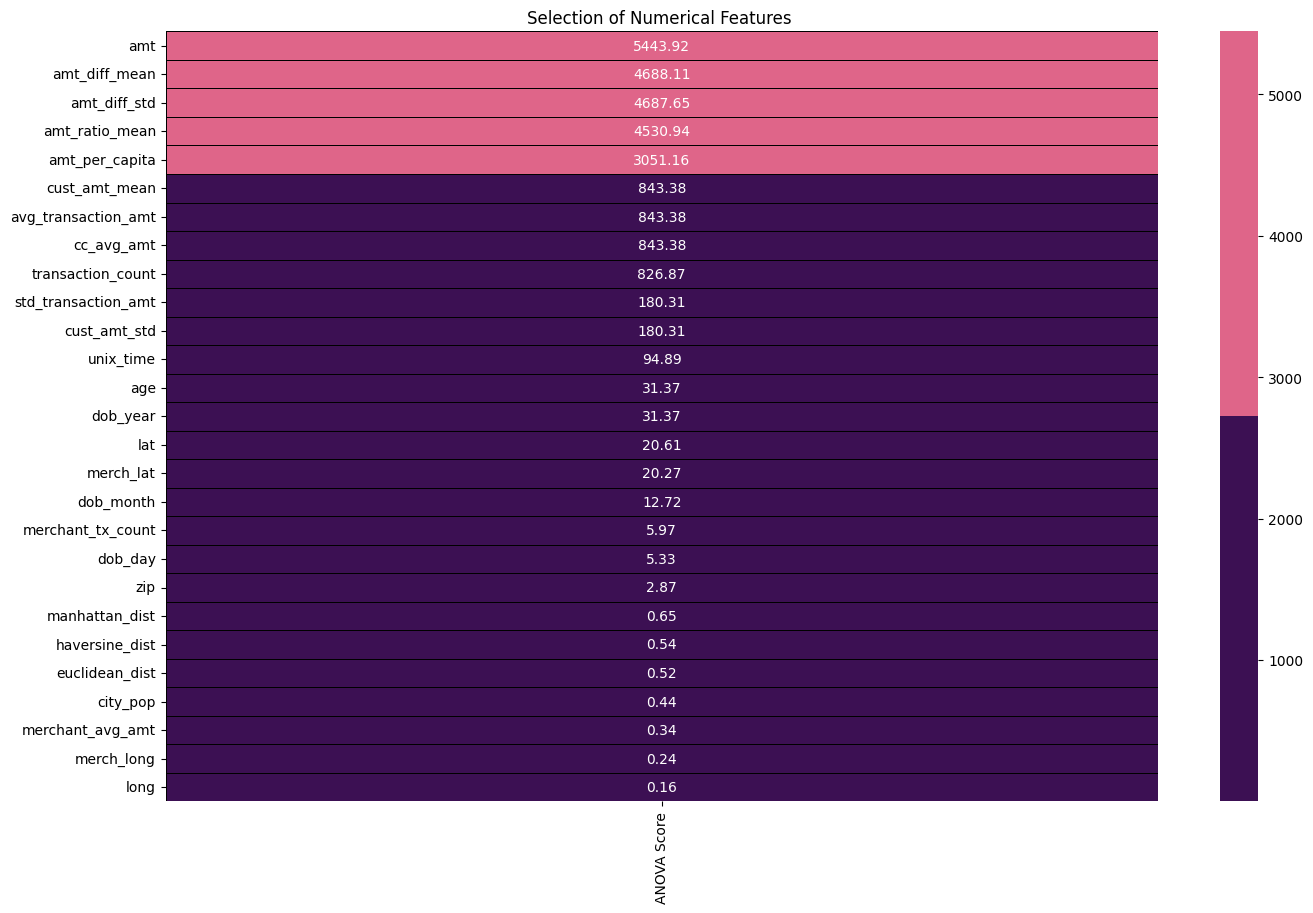

In [500]:
from sklearn.feature_selection import f_classif
colors = ['#3C1053', '#DF6589']
discrete_columns = [col for col in discrete_features if col not in ['cc_num']]

fig, ax = plt.subplots(figsize=(16, 10)) 

features = X_train.loc[:, discrete_columns]
target = y_train

best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, target)

featureScores_train = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA Score'])
sorted_featureScores_train = featureScores_train.sort_values(ascending=False, by='ANOVA Score')

sns.heatmap(sorted_featureScores_train, annot=True, cmap=colors, linewidths=0.4, linecolor='black', fmt='.2f', annot_kws={'size': 10})
plt.title('Selection of Numerical Features ')

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()


In [501]:
#drop feattures that have p_value>0.05 in anova test
from sklearn.feature_selection import SelectKBest, f_classif
discrete_features = []
for i in col:
    if len(train_df[i].unique()) > 6:
        discrete_features.append(i)
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(X_train.loc[:, discrete_columns], y_train)

p_values_anova = best_features.pvalues_
unimportant_features_anova = [X_train.columns[i] for i in range(len(p_values_anova)) if p_values_anova[i] > 0.05]

print("Unimportant features (p-value > 0.05):")
print(unimportant_features_anova)


Unimportant features (p-value > 0.05):
['amt', 'lat', 'long', 'merch_lat', 'amt_per_capita', 'haversine_dist', 'manhattan_dist', 'amt_ratio_mean']


In [502]:
X_train = X_train.drop(columns=unimportant_features_anova)
X_test = X_test.drop(columns=unimportant_features_anova)

In [504]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_classif

columns_to_consider = [col for col in train_df.columns if col not in ['cc_num']]
X = train_df[columns_to_consider]

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Filter features with high VIF
high_vif_features = vif_data[vif_data["VIF"] > 15]["Feature"].tolist()

# Compute ANOVA F-statistic
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(X, train_df['is_fraud'])  

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'ANOVA F-Statistic': fit.scores_
})

# Generate pairwise correlations 
corr_matrix = X[high_vif_features].corr()
high_corr_pairs = []
processed = set()

for row in high_vif_features:
    for col in high_vif_features:
        if row != col and (col, row) not in processed:
            processed.add((row, col))
            corr_val = corr_matrix.loc[row, col]
            if abs(corr_val) > 0.95:
                high_corr_pairs.append((row, col, corr_val))

features_to_delete = []

for feature1, feature2, _ in high_corr_pairs:
    f_stat1 = feature_scores.loc[feature_scores['Feature'] == feature1, 'ANOVA F-Statistic'].values[0]
    f_stat2 = feature_scores.loc[feature_scores['Feature'] == feature2, 'ANOVA F-Statistic'].values[0]
    
    if f_stat1 < f_stat2:
        features_to_delete.append(feature1)
    else:
        features_to_delete.append(feature2)

features_to_delete = list(set(features_to_delete))  

print("\n🗑️ Features to delete due to high VIF and low ANOVA F-statistic:")
print(features_to_delete)



🗑️ Features to delete due to high VIF and low ANOVA F-statistic:
['long', 'amt_ratio_mean', 'amt_diff_mean', 'haversine_dist', 'cust_amt_mean', 'cust_amt_std', 'cc_avg_amt', 'gender_F', 'euclidean_dist', 'dob_year', 'merch_lat', 'amt_diff_std']


In [507]:
features_to_delete=['amt_diff_mean', 'cust_amt_mean', 'cust_amt_std', 'cc_avg_amt', 'gender_F', 'euclidean_dist', 'dob_year',  'amt_diff_std']
X_train = X_train.drop(columns=features_to_delete)
X_test= X_test.drop(columns=features_to_delete)

In [509]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

## Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = MinMaxScaler()

train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])
